In [1]:
import sys
sys.path.append('../code')
# sys.path.append('../externals/mamba/')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import ShuffleSplit
import pickle
import model_utils
from torch import nn
from mamba_ssm import Mamba
import Neural_Decoding


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
# device = torch.device('cpu')

torch.backends.cudnn.benchmark = True


In [2]:
noise_fold = 0
data_dict = model_utils.get_marker_decode_dataframes(noise_fold=noise_fold)
wrist_df = data_dict['wrist_df']
task_neural_df = data_dict['task_neural_df']
notask_neural_df = data_dict['notask_neural_df']
metadata = data_dict['metadata']
cv_dict = data_dict['cv_dict']

neuron_list = notask_neural_df['unit'].unique()

notask_time_neural_mask = notask_neural_df['unit'] != 'time'
notask_neural_df = notask_neural_df[notask_time_neural_mask]

task_time_neural_mask = task_neural_df['unit'] != 'time'
task_neural_df = task_neural_df[task_time_neural_mask]

wrist_mask = wrist_df['name'] != 'time'
wrist_df = wrist_df[wrist_mask]

In [3]:
neural_offset = 10 # try 50-150 ms offset
window_size = 70
label_col = 'layout'

In [4]:
#LSTM/GRU architecture for decoding
#RNN architecture for decoding kinematics
class model_mamba(nn.Module):
    def __init__(self, input_size, output_size, d_model, d_state=16, d_conv=4, expand=2, dropout=0.2, device=device,
                 cat_features=None, task_info=True):
        super(model_mamba, self).__init__()

        # Defining some parameters
        self.device = device
        self.dropout = dropout
        self.cat_features = cat_features
        self.task_info = task_info

        self.input_size = input_size

        if self.cat_features is not None:
            self.num_cat_features = np.sum(self.cat_features).astype(int)
            self.input_size = self.input_size - self.num_cat_features

            
        # self.fc = nn.Linear(in_features=d_model, out_features=output_size).to(device)
        self.fc1 = model_utils.model_ann(d_model, output_size, [100, 100]).to(device)
        self.fc2 = nn.Linear(in_features=output_size, out_features=output_size).to(device)
        self.dropout = nn.Dropout(p=self.dropout)

        # self.fc = nn.Linear((input_), output_size)
        self.mamba = Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand).to(device)
    
    def forward(self, x):

        if not self.task_info:
            x[:, :, self.cat_features] = 0.0
            x[:,:,-np.random.choice([0,1,2,3])] = 1.0

        batch_size = x.size(0)

        out = self.mamba(x)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out, None, None


class model_cnn(nn.Module):
    def __init__(self, device='cpu'):
        super(model_cnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, stride=3)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=3)
        self.fc1 = nn.Linear(1008, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        print(x.shape)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
#LSTM/GRU architecture for decoding
#RNN architecture for decoding kinematics
class model_lstm(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, dropout, device, bidirectional=False,
                 cat_features=None, task_info=True):
        super(model_lstm, self).__init__()

        #multiplier based on bidirectional parameter
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1

        # Defining some parameters
        self.hidden_dim = hidden_dim       
        self.n_layers = n_layers * num_directions
        self.device = device
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.cat_features = cat_features
        self.input_size = input_size
        self.task_info = task_info

            
        self.fc = nn.Linear(self.hidden_dim * num_directions, output_size)

        self.lstm = nn.LSTM(self.input_size, self.hidden_dim, n_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional) 
    
    def forward(self, x):
        batch_size = x.size(0)
        # Initializing hidden state for first input using method defined below

        if not self.task_info:
            x[:, :, self.cat_features] = 0.0
            x[:,:,-np.random.choice([0,1,2,3])] = 1.0

        hidden, cell = self.init_hidden(batch_size)

        out_lstm, (hidden, cell) = self.lstm(x, (hidden, cell))

        out_final = out_lstm.contiguous()
        out_final = self.fc(out_final)
        return out_final, hidden, cell
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data.to(self.device)

        #LSTM initialization
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)
        cell = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device) + 1

        return hidden, cell

In [6]:
def run_rnn(pred_df, neural_df, neural_offset, cv_dict, metadata, task_info=True,
            window_size=50, num_cat=0, label_col=None, flip_outputs=False, dropout=0.5):
    exclude_processing = None
    criterion = model_utils.mse
    if num_cat > 0:
        exclude_processing = np.zeros(len(neural_df['unit'].unique()))
        exclude_processing[-num_cat:] = np.ones(num_cat)
        exclude_processing = exclude_processing.astype(bool)

    # else:
    #     criterion = mse

    data_arrays, generators = model_utils.make_generators(
    pred_df, neural_df, neural_offset, cv_dict, metadata, exclude_neural=exclude_processing,
    window_size=window_size, flip_outputs=flip_outputs, batch_size=1000, label_col=label_col, fold=1)

    # Unpack tuple into variables
    training_set, validation_set, testing_set = data_arrays
    training_generator, training_eval_generator, validation_generator, testing_generator = generators

    X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
    y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

    X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
    y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

    #Define hyperparameters
    lr = 1e-3
    # weight_decay = 1e-4
    weight_decay = 1e-4
    hidden_dim = 600
    n_layers = 2
    max_epochs = 1000
    input_size = X_train_data.shape[1] 
    output_size = y_train_data.shape[1] 

    model_rnn = model_lstm(input_size, output_size, hidden_dim, n_layers, dropout,
                                       device, cat_features=exclude_processing, task_info=task_info).to(device)

    # model_rnn = model_mamba(input_size, output_size, d_model=input_size,
    #                         d_state=128, d_conv=4, expand=2, cat_features=exclude_processing,
    #                         task_info=task_info)


    # Define Loss, Optimizerints h
    optimizer = torch.optim.Adam(model_rnn.parameters(), lr=lr, weight_decay=weight_decay)

    #Train model
    loss_dict = model_utils.train_validate_model(model_rnn, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)

    #Evaluate trained model
    rnn_train_pred = model_utils.evaluate_model(model_rnn, training_eval_generator, device)
    rnn_test_pred = model_utils.evaluate_model(model_rnn, testing_generator, device)

    rnn_train_corr = model_utils.matrix_corr(rnn_train_pred, y_train_data)
    rnn_test_corr = model_utils.matrix_corr(rnn_test_pred, y_test_data)

    res_dict = {'loss_dict': loss_dict,
                'train_pred': rnn_train_pred, 'test_pred': rnn_test_pred,
                'train_corr': rnn_train_corr, 'test_corr': rnn_test_corr}

    return model_rnn, res_dict

def run_wiener(pred_df, neural_df, neural_offset, cv_dict, metadata, task_info=True,
               window_size=50, num_cat=0, label_col=None, flip_outputs=False, dropout=0.5):

    exclude_processing = None
    criterion = model_utils.mse
    if num_cat > 0:
        exclude_processing = np.zeros(len(neural_df['unit'].unique()))
        exclude_processing[-num_cat:] = np.ones(num_cat)
        exclude_processing = exclude_processing.astype(bool)

    # else:
    #     criterion = mse

    data_arrays, generators = model_utils.make_generators(
    pred_df, neural_df, neural_offset, cv_dict, metadata, exclude_neural=exclude_processing,
    window_size=window_size, flip_outputs=flip_outputs, batch_size=1000, label_col=label_col, fold=1)

    # Unpack tuple into variables
    training_set, validation_set, testing_set = data_arrays
    training_generator, training_eval_generator, validation_generator, testing_generator = generators

    X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
    y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

    X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
    y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()


    #Fit and run wiener filter
    model_wr = Neural_Decoding.decoders.WienerFilterDecoder() 
    model_wr.fit(X_train_data,y_train_data)

    wr_train_pred = model_wr.predict(X_train_data)
    wr_test_pred = model_wr.predict(X_test_data)

    #Compute decoding
    wr_train_corr = model_utils.matrix_corr(wr_train_pred,y_train_data)
    wr_test_corr = model_utils.matrix_corr(wr_test_pred,y_test_data)

    res_dict = {'train_pred': wr_train_pred, 'test_pred': wr_test_pred,
                'train_corr': wr_train_corr, 'test_corr': wr_test_corr}

    return model_wr, res_dict


In [7]:
# func_dict = {'wiener': contrastive_functions.run_wiener, 'rnn': contrastive_functions.run_rnn}
func_dict = {'rnn': run_rnn, 'wiener': run_wiener}
# func_dict = {'rnn': run_wiener}

fpath = '../data/neuron_num_results/'

num_repeats = 1

num_neuron_results_dict = {'noise_fold': noise_fold}


# df_dict = {'task': {'df': task_neural_df, 'task_info': True, 'num_cat': 4, 'flip_outputs': True},
#             'notask': {'df': notask_neural_df, 'task_info': False, 'num_cat': 0, 'flip_outputs': True}}

df_dict = {'task': {'df': task_neural_df, 'task_info': True, 'num_cat': 4, 'flip_outputs': True},
            'notask': {'df': task_neural_df, 'task_info': False, 'num_cat': 4, 'flip_outputs': True}}

           
decode_results = dict()
for func_name, func in func_dict.items():
    decode_results[func_name] = dict()
    for df_type, pred_df in df_dict.items():
        # print(f'{func_name}_{df_type} num_neurons: {num_neurons}; repeat {repeat_idx}')

        model, res_dict = func(wrist_df, pred_df['df'], neural_offset, cv_dict, metadata, task_info=pred_df['task_info'],
                                window_size=window_size, num_cat=pred_df['num_cat'], label_col=label_col, flip_outputs=pred_df['flip_outputs'])

        decode_results[func_name][df_type] = res_dict

        # # Save results on every loop in case early stop
        # num_neuron_results_dict[f'repeat_{repeat_idx}'][f'num_neuron_{num_neurons}'] = decode_results
        # # #Save metadata
        # output = open(f'{fpath}num_neuron_results.pkl', 'wb')
        # pickle.dump(num_neuron_results_dict, output)
        # output.close()

        # if func_name == 'rnn':
        #     torch.save(model.state_dict(), f'{fpath}models/{df_type}_neurons{num_neurons}_repeat{repeat_idx}.pt')





**...*....
Epoch: 10/1000 ... Train Loss: 0.1014  ... Validation Loss: 0.6636
.. Early Stop; Min Epoch: 6
*.**.*....
Epoch: 10/1000 ... Train Loss: 0.1023  ... Validation Loss: 0.5823
.. Early Stop; Min Epoch: 6


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f6825722980>]}

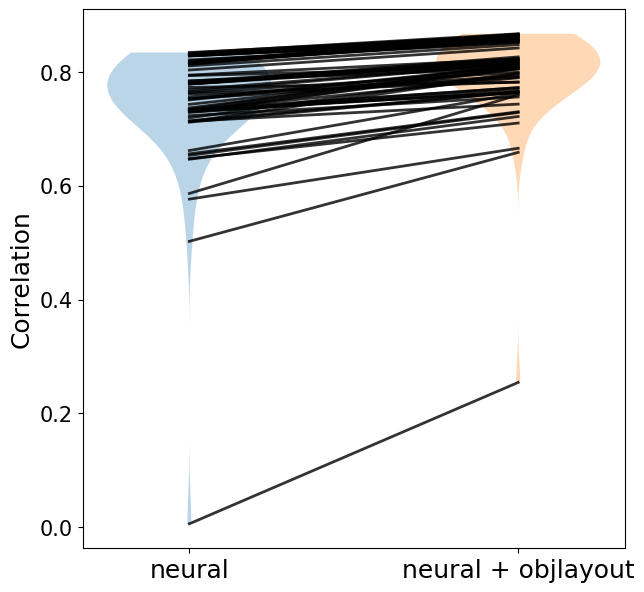

In [8]:
decoder_type = 'rnn'
cond1, cond2 = 'notask', 'task'

labelsize=18
ticksize=15

nolayout_test_corr = decode_results[decoder_type][cond1]['test_corr']
all_test_corr = decode_results[decoder_type][cond2]['test_corr']

plt.figure(figsize=(7,7))

plot_data = np.stack([nolayout_test_corr, all_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1], labels=['neural', 'neural + objlayout'], fontsize=labelsize)
plt.yticks(fontsize=ticksize)
plt.ylabel('Correlation', fontsize=labelsize)
plt.violinplot(nolayout_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
# plt.title('All Marker Decoding', fontsize=16)
# plt.ylim([-0.05,0.9])
# plt.savefig(f'../figures/mamba_layout_violin.png')
# plt.savefig(f'../figures/lstm_layout_violin.png')



{'bodies': [<matplotlib.collections.PolyCollection at 0x7f6843f93610>]}

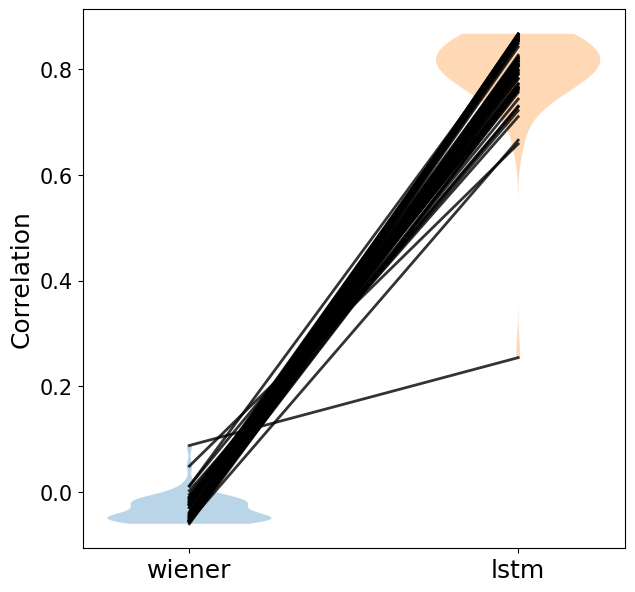

In [9]:
decoder_type = 'rnn'
cond = 'task'

labelsize=18
ticksize=15

wiener_test_corr = decode_results['wiener'][cond]['test_corr']
lstm_test_corr = decode_results['rnn'][cond]['test_corr']

plt.figure(figsize=(7,7))

plot_data = np.stack([wiener_test_corr, lstm_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1], labels=['wiener', 'lstm'], fontsize=labelsize)
plt.yticks(fontsize=ticksize)
plt.ylabel('Correlation', fontsize=labelsize)
plt.violinplot(wiener_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(lstm_test_corr, positions=[1], showmeans=False,showextrema=False)
# plt.title('All Marker Decoding', fontsize=16)
# plt.ylim([-0.05,0.9])
# plt.savefig(f'../figures/mamba_layout_violin.png')
# plt.savefig(f'../figures/lstm_layout_violin.png')



In [10]:
exclude_processing = None

data_arrays, generators = model_utils.make_generators(
wrist_df, task_neural_df, neural_offset, cv_dict, metadata, exclude_neural=exclude_processing,
window_size=window_size, flip_outputs=True, batch_size=1000, label_col=label_col, fold=1)

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

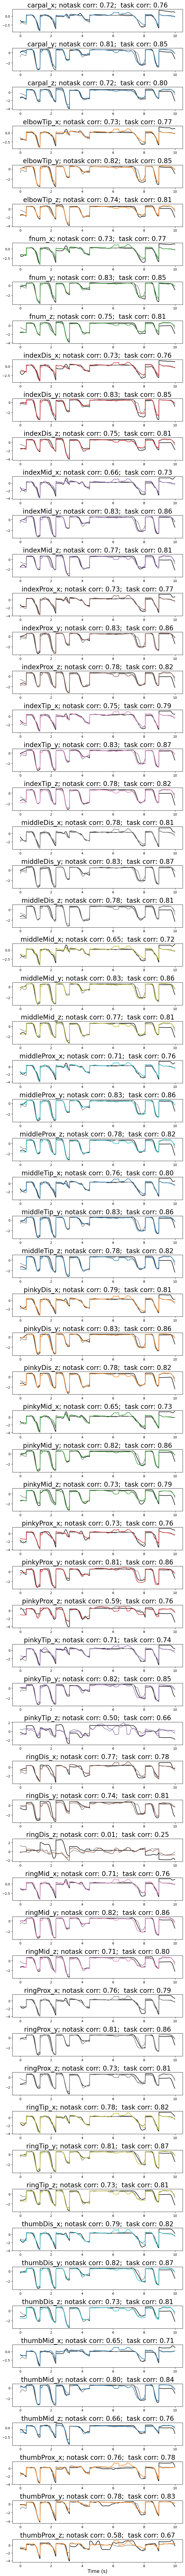

In [13]:
marker_list = ['carpal', 'elbowTip', 'fnum', 'indexDis',
       'indexMid', 'indexProx', 'indexTip', 'middleDis', 'middleMid',
       'middleProx', 'middleTip', 'pinkyDis', 'pinkyMid', 'pinkyProx',
       'pinkyTip', 'ringDis', 'ringMid', 'ringProx', 'ringTip',
       'thumbDis', 'thumbMid', 'thumbProx']
labelsize = 15
ticksize=10
time_offset = 500

bounds = list(range(2000+time_offset,3000+time_offset))
x_times = np.arange(len(bounds)) / 100 # Sampling rate=100 Hz

# repeat_name = 'repeat_0'
# num_neuron_name = 'num_neuron_15'

plt.figure(figsize=(8,len(marker_list) * 5))

marker_counter = 0
coord_idx = 0
coord_names = ['x','y','z']
for mrk_idx in range(len(marker_list) * 3):
    if mrk_idx % 3 == 0:
        marker_counter += 1
        coord_idx = 0
    coord_idx += 1

    plt.subplot(len(marker_list) * 3,1,mrk_idx+1)
    notask_corr = np.corrcoef(y_test_data[:,mrk_idx], decode_results['rnn']['notask']['test_pred'][:,mrk_idx])
    task_corr = np.corrcoef(y_test_data[:,mrk_idx], decode_results['rnn']['task']['test_pred'][:,mrk_idx])


    plt.plot(x_times, y_test_data[bounds,mrk_idx], color='k', label='DLC Marker')
    plt.plot(x_times, decode_results['rnn']['notask']['test_pred'][bounds,mrk_idx], color='grey', label='RNN Pred')
    plt.plot(x_times, decode_results['rnn']['task']['test_pred'][bounds,mrk_idx], color=f'C{marker_counter-1}')

    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.title(f'{marker_list[marker_counter-1]}_{coord_names[coord_idx-1]}; notask corr: {notask_corr[0,1]:.2f};  task corr: {task_corr[0,1]:.2f}', fontsize=20)
plt.xlabel('Time (s)', fontsize=labelsize)

plt.tight_layout()
# plt.savefig('../figures/mamba_layout_trajectory.png')
# plt.savefig('../figures/lstm_layout_trajectory.png')




(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 10.0, '10.0'),
  Text(0, 12.5, '12.5'),
  Text(0, 15.0, '15.0'),
  Text(0, 17.5, '17.5'),
  Text(0, 20.0, '20.0')])

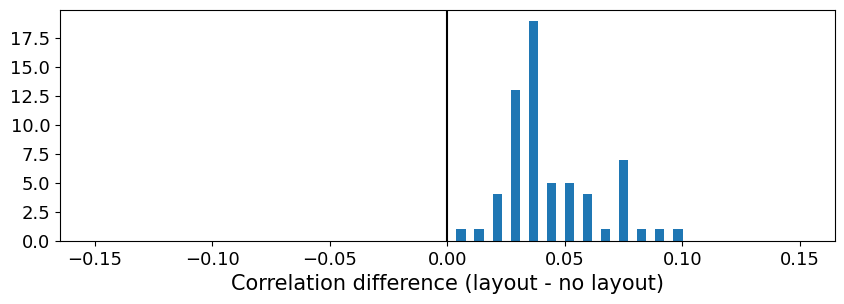

In [14]:
corr_diff = all_test_corr - nolayout_test_corr

ticksize=13
plt.figure(figsize=(10,3))
bins=np.linspace(-0.15, 0.15, 40)
_ = plt.hist(corr_diff, bins=bins, width=0.004)
plt.axvline(x=0, color='k')
plt.xlabel('Correlation difference (layout - no layout)', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
# plt.savefig('../figures/mamba_layout_hist.png')
# plt.savefig('../figures/lstm_layout_hist.png')